# Food-101 Challenge

---
* I'm training this model on Colab due to my hardware and bandwidth limitations.
* The dataset is very big (~5 GB), so I would suggest you do the same. Although, fair warning, there are some issues I faced while training, which I've explained in detail below. I would really appreciate comments/suggestions on things which I could have done/implemented in a better way. Thank you!
---

## 1) We start off by downloading the dataset to Colab 


*   I initially tried to download the whole dataset to my Google Drive and extract it there itself. But the whole operation takes a lot of time
*   I would suggest first downloading the archive to Colab, extract it, and then copy the Train and Test sets to Google Drive if needed



In [ ]:
import requests 
file_url = "http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz"
 
r = requests.get(file_url, stream = True) 

In [ ]:
with open("/content/food-101.tar.gz", "wb") as file: 
    for block in r.iter_content(chunk_size = 1024): 
        if block: 
            file.write(block) 

## 2) Extract images and metadata from the archive

In [ ]:
import tarfile
tar = tarfile.open("food-101.tar.gz", "r:gz")
tar.extractall()
tar.close()

## 3) Confirm all images have downloaded

In [4]:
import os

nofiles = 0
nodir = 0
home = "/content/food-101/images"

for base, dirs, filess in os.walk(home):
  for directories in dirs:
    nodir += 1
  for Files in filess:
    nofiles += 1
print(nofiles)
print(nodir)

101000
101


## 4) Define a function to copy/split images based on file names in **train.txt** and **test.txt**

* Normally to split datasets into train-val-test sets, I use [this](https://pypi.org/project/split-folders/) library. You can split your whole dataset in just one line! 
* But, when I tried it on Colab, it took forever to split the dataset. Hence, this function


In [ ]:
from collections import defaultdict
from shutil import copy

def prepare_data(filepath,src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

  

## 5) Copy training images into a different folder called **train**

In [6]:
print("Creating training data...")
prepare_data('/content/food-101/meta/train.txt', '/content/food-101/images', '/content/food-101/train')

Creating training data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying

## 6) Copy test images into a different folder called **test**

In [7]:
print("Creating testing data...")
prepare_data('/content/food-101/meta/test.txt', '/content/food-101/images', '/content/food-101/test')

Creating testing data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying 

## 7) View some random image from the dataset

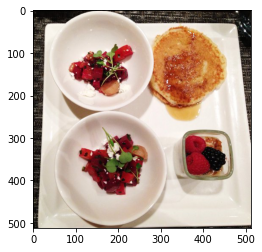

3643559.jpg


In [12]:
import sys
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

random.seed(11)

path = "/content/food-101/train/beet_salad"

def randomize_file():
	return random.choice(os.listdir(path))

def print_random_filename(random_file):
    random_filename = random_file.split(".jpg")[0]
    img=mpimg.imread(path+'/'+random_file)
    imgplot = plt.imshow(img)
    plt.show()
    print(random_file)

random_file = random.choice(os.listdir(path))

if random_file.startswith('.'):
	new_random_file = randomize_file()
	print_random_filename(new_random_file)
else:
    print_random_filename(random_file)


## 8) Import dependencies and define **ImageDataGenerator** for both the training and testing sets
* I've used a limited number of augmentations as I've found these to contribute most towards increasing the model accuracy
* Also, I had a look at the input data. Some transforms like *channel_shift_range* , _zca_epsilon_ don't really make sense for this dataset. So, when you preprocess your data, have a look at it and visually try to determine what your test images *might* look like and then apply augmentations
* Confirm the number of images for your train and test sets in the output
* I've added ```shuffle=True``` as it helps while training when you have a large dataset

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.2,rotation_range=40,horizontal_flip=True,shear_range=0.2, fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/food-101/train',  
        target_size=(299, 299),
        batch_size=32,
        shuffle=True,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        '/content/food-101/test',  
        target_size=(299, 299), 
        batch_size=32,
        shuffle=True,
        class_mode='categorical')


Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


## 9) Visualize the augmented batch of pictures for the above picture

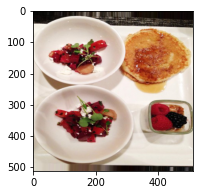

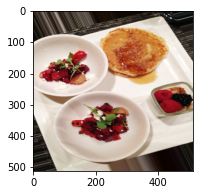

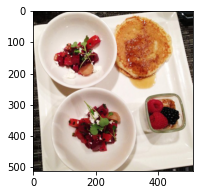

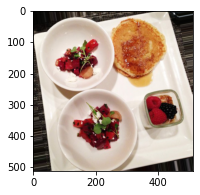

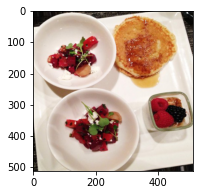

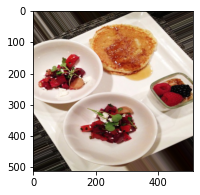

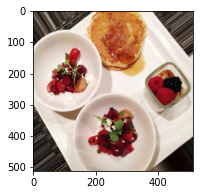

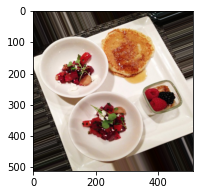

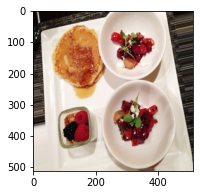

In [31]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot

img = load_img('/content/food-101/train/beet_salad/3643559.jpg')
data = img_to_array(img)
samples = expand_dims(data, 0)
datagen = ImageDataGenerator(zoom_range=0.2,rotation_range=40,horizontal_flip=True,shear_range=0.2, fill_mode='nearest')
it = datagen.flow(samples, batch_size=1)
for i in range(9):
  pyplot.figure(figsize=(10,10))
  pyplot.subplot(330 + 1 + i)
  batch = it.next()
  image = batch[0].astype('uint8')
  pyplot.imshow(image)
pyplot.show()

## 10) Use a pre-trained model via Transfer Learning and add classification layers at the top
![Documentation for individual models](https://cdn-images-1.medium.com/freeze/max/1000/1*_lf5dJj2GxURaRCDAY9jxA.png?q=20)

* The challenge asked us to use a model like ResNet or smaller
* Initially when I used ResNet, while training, the model used to get stuck a local minima (my guess), because I've spent almost two days debugging the model and that was the best explanation I could come up with
* Hence I used Xception as a base model as it has nearly the same number of parameters and added some classification and normalization layers on top
* I took the input shape as ```(299,299,3)``` as those are the original dimensions used to train the Xception model
> Adding ``` Activation('relu') ``` after the dense layer and not as an argument to the ``` Dense() ``` layer made some noticeable difference to the accuracy. I did this as I came across a Stack Overflow suggestion while debugging the model. Didn't find a logical explanation for this though

* [Here's](https://github.com/keras-team/keras/issues/1761#issuecomment-186122714) a really helpful post on sanity checks to perform while building your model. Do give it a read!


In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Activation, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import regularizers
xception = Xception(include_top=False, weights='imagenet', input_shape=(299, 299, 3))
xception.trainable = False

out = xception.output
out = GlobalAveragePooling2D()(out)
out = Flatten()(out)
out = Dense(256)(out)
out = Activation('relu')(out)
out = BatchNormalization()(out)
out = Dropout(0.3)(out)
out = Dense(101, activation='softmax')(out)
xception_refined = Model(inputs=xception.input, outputs=out)

xception_refined.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
83689472/83683744 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149

## 11) Define callbacks and fit the Image Generator

* I couldn't finish training model as I had exhausted my Google Cloud GPU privileges by then. I had reached an accuracy of **~65%** when Colab disconnected.
* But, the model was learning at an almost steady rate. So I guess the accuracy would reach an acceptable amount given enough time
* In my opinion, this is justified as the amount of data was really huge and given the inherent limitations of cloud computing
* One of the major issues while training huge models on Colab is that the runtime gets disconnected when you don't interact with it regularly. Absolute timeout for a notebook is 12 hours. I've found two solutions for this. The first one didn't work for me, but did for others. Second one will surely work!

1.   Open up your browser console and run the following script 

``` 
function ClickConnect(){
  console.log("Working"); 
  document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect,60000)

```

2.   Copy this code to a new file on *your* laptop/PC and run it. Then open up Colab and place your mouse on any directory in the left side panel. The script imitates a left click every 30 seconds. This counts as interaction and won't disconnect your runtime.

```
from pynput.mouse import Button, Controller
import time

mouse = Controller()

while True:
    mouse.click(Button.left, 1)
    time.sleep(30)
```


In [ ]:
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Define a Callback class that stops training once accuracy reaches 95%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks=myCallback()
checkpointer = ModelCheckpoint(filepath='/content/drive/My Drive/model_checkpoint2.hdf5',
                               verbose=1, 
                               save_best_only=True)

resnet_refined.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])


history = resnet_refined.fit_generator(
      train_generator,
      steps_per_epoch=2368,  
      epochs=50,
      verbose=1,
      shuffle=True,
      validation_data = validation_generator,
      validation_steps=790,
      callbacks=[callbacks, checkpointer])

model.save('/content/drive/My Drive/trained_model.hdf5')

Epoch 1/50
 790/2368 [=========>....................] - ETA: 5:52 - loss: 2.1396 - acc: 0.4441
Epoch 00001: val_loss improved from inf to 2.13959, saving model to /content/drive/My Drive/model_checkpoint2.hdf5
2368/2368 [==============================] - 1993s 842ms/step - loss: 2.5429 - acc: 0.3861 - val_loss: 2.1396 - val_acc: 0.4441
Epoch 2/50
 789/2368 [========>.....................] - ETA: 5:56 - loss: 1.7504 - acc: 0.4933
Epoch 00002: val_loss improved from 2.13959 to 1.7505, saving model to /content/drive/My Drive/model_checkpoint2.hdf5
2368/2368 [==============================] - 1963s 829ms/step - loss: 2.0467 - acc: 0.4790 - val_loss: 1.7505 - val_acc: 0.4932
Epoch 3/50
 789/2368 [========>.....................] - ETA: 5:06 - loss: 1.6428 - acc: 0.5098
Epoch 00003: val_loss improved from 1.75052 to 1.6428, saving model to /content/drive/My Drive/model_checkpoint2.hdf5
2368/2368 [==============================] - 1880s 794ms/step - loss: 1.7622 - acc: 0.5182 - val_loss: 1.642

## 12) Further 

* I know this isn't a full solution but I've really tried to work on this as much as possible. And I'm really sure that upon further training, the model will be able to accomplish the required top-1 classification accuracy

  
